In [9]:

# Import Libraries
import os
import bayesflow as bf
import numpy as np
import math
import os
import pickle
import sys
import pandas as pd
import seaborn as sns
import time
import tensorflow as tf
from bayesflow import computational_utilities as utils
from numba import njit
import re
import matplotlib.pyplot as plt
from datetime import datetime
from functools import partial
from bayesflow.computational_utilities import maximum_mean_discrepancy
from keras.utils import to_categorical


In [11]:
myhost

'x-ray-199.dynamic2.rpi.edu'

In [12]:
myhost = os.uname()[1]

RNG = np.random.default_rng(2023)
model_start = datetime.now()
#%%


if myhost == 'psyml201' or myhost == 'nagini-59.dynamic.rpi.edu' or myhost == 'x-ray-199.dynamic2.rpi.edu':
    index = 496
    design_grid_num = 6
    slurm_id = 'PC'
    model_title =  None
    design_grid_num = 6
    # model_title = 'dmc_418664design_grid6_condition54'
    design_grid_dir = '/data/design_grid' + str(design_grid_num) + '.csv'
else:
    arguments = sys.argv[1:]
    print(f"passed argument: {arguments}")
    index = int(arguments[1])
    design_grid_num = int(arguments[2])
    slurm_id = str(arguments[0])
    model_title = "dmc_"+ str(arguments[0]) + 'design_grid' + str(design_grid_num)+ '_condition' + str(index)
    design_grid_dir = '/data/design_grid' + str(design_grid_num) + '.csv'



In [13]:


model_info = {
    'model_title': model_title,
    'link_function': None, # choose 'normal cdf' to transform normals to uniform priors
    'normal_restriction': 'positive only',
    'model': 'dmc',
    'log_file': 'dmc_log_file.csv',
    'slurm_id': slurm_id,
    'write_log': True,
    'load_pretrained': True,
    'save_plots': True,
    'compute_mmd': True,
    'plot_mms': False,
    'plot_dataspace': True,
    'save_rt_data': False,
    'x0_var': 'trial', # or 'fixed' -> specify X0_beta_shape
    'a_var': 'estimated', # or 'fixed'
    'a_value': None,
    'n_epochs': 100,
    'n_iterations': 1000,
    'min_obs': 50,
    'max_obs': 2000,
    'n_conditions': 2,
    'batch_size': 32,
    'save_posterior_data': True,
    'n_summary_dims': 32,
    'coupling_design': "spline", # oder spline
    'n_coupling_layers': 12,
    'n_validation_sims': 200,
    'early_stopping': False,
    ## Priors ##
    'X0_beta_shape_fixed': 3,
    'X0_value': 0,
    'tmax': 1200,
    'sigma': 4,
    'dt': 1,
    'n_recovery_simulations': 1000,
    'n_posterior_samples': 10000,
    'simulation_function': 'vectorized',
    'nonconvergents': 'resampled',
    'dir_design_grid': design_grid_dir,
    'start_time': model_start,
    'comment': 'extended x_shape range (Luo & proctor, 2022), a fixed',
    'attention_setting_key_dim': 128,
    'num_heads': 8,
    'num_inducing_points': 32,
    'num_seeds': 4,
    'num_dense_fc': 2,
    'dense_setting_units': 256,
    'dense_setting_activation': 'relu',
    'min_scale_alpha': 1,
    'max_scale_alpha': 1,
    'learning_rate': 5e-4}


if myhost == 'psyml201' or myhost == 'nagini-59.dynamic.rpi.edu':
    # model_info['save_plots'] = False
    model_info['plot_mms'] = False
    model_info['compute_mmd'] = False
    model_info['plot_dataspace'] = False


parent_dir = '/Users/simonschaefer/Documents/BF-LIGHT'

if model_info['load_pretrained']:
    # model titles
    list_files = os.listdir(parent_dir + '/networks')
    list_files =  [path for path in list_files if 'design_grid6' in path]
    model_title = [path for path in list_files if 'condition'+ str(index) in path]
    model_title.sort()
    model_title = model_title[0]
    model_info['model_title'] = model_title


script_dir = str(parent_dir) + '/models'

functions_dir = parent_dir + '/functions'

model_data_dir = parent_dir + '/model_data'

model_dir = parent_dir + '/models'

figure_path = parent_dir + '/plots/' + model_title + '/' + model_title

print('script_dir = '+script_dir)
print('parent_dir = '+parent_dir)
print('functions_dir = '+functions_dir)
print('model_data_dir = '+model_data_dir)
print('model_dir = '+model_dir)
print('design_grid_dir = '+design_grid_dir)

sys.path.append(functions_dir)



import dmc_functions as dmc



script_dir = /Users/simonschaefer/Documents/BF-LIGHT/models
parent_dir = /Users/simonschaefer/Documents/BF-LIGHT
functions_dir = /Users/simonschaefer/Documents/BF-LIGHT/functions
model_data_dir = /Users/simonschaefer/Documents/BF-LIGHT/model_data
model_dir = /Users/simonschaefer/Documents/BF-LIGHT/models
design_grid_dir = /data/design_grid6.csv


In [14]:
model_title


'dmc_602907design_grid6_condition496'

In [15]:
## read design grid

design_grid = pd.read_csv(parent_dir+model_info['dir_design_grid'], index_col=0)


# if myhost != 'psyml201':
#     # write slurm id into design grid
#     design_grid['slurm_id'][index] = slurm_id
#     design_grid.to_csv(parent_dir+model_info['dir_design_grid'])

# replace NaN with None
design_grid.replace({np.nan: None})

condition = design_grid.iloc[index]

condition.to_dict()

model_info.update(condition)

sys.path.append(parent_dir)

# parameters estimated
param_names = ['A', 'tau', 'mu_c', 'mu_r', 'b']
PARAM_NAMES = [r'$A$', r'$\tau$', r'$\mu_c$',r'$\mu_r$', r'$b$']

# append parameter names if needed
if model_info['sd_r_var'] == 'estimated':
    param_names.append('sd_r')
    PARAM_NAMES.append(r'$sd_r$')

if model_info['a_var'] == 'estimated':
    param_names.extend('a')
    PARAM_NAMES.append(r'$a$')

n_pars = len(param_names)

families_list = [name + '_prior' for name in param_names]

prior_families = [model_info[key] for key in families_list if key in model_info]

restriction = model_info['normal_restriction']
link_fun = model_info['link_function']

## extract prior parameters from model_info

prior_par_names = []
prior_pars_arr = np.zeros((n_pars, 2))
# prior_pars_arr = np.concatenate((prior_pars_arr, np.array(param_names).reshape(n_pars,1)), axis = 1)

for i in range(n_pars):
    if prior_families[i] == 'gamma':
        suffix = ['shape', 'rate']
    elif prior_families[i] == 'normal':
        suffix = ['mean', 'sd']

    for j in range(len(suffix)):
        par_name = param_names[i] + '_prior_' + suffix[j]
        prior_par_names.append(par_name)
        prior_pars_arr[i, j] = model_info[par_name]



# model_info['tmax'] = 5000
# prior_batchable_fun = partial(dmc.alpha_gen,
#                         min = model_info['min_scale_alpha'],
#                         max = model_info['max_scale_alpha'],
#                         size = n_pars)

# prior_fun(prior_batchable_fun())
# context_alpha = partial(dmc.alpha_gen,
#                         min = 1,
#                         max = 1,
#                         size = n_pars)
# single test prior function

# prior_context = bf.simulation.ContextGenerator(batchable_context_fun=prior_batchable_fun)




In [16]:
param_names

['A', 'tau', 'mu_c', 'mu_r', 'b']

In [17]:
prior_fun_win_sim = partial(dmc.prior_nps,
                    families = np.array(prior_families),
                    pars1 = prior_pars_arr[:,0],
                    pars2 = prior_pars_arr[:,1],
                    param_names = np.array(param_names),
                    restriction = restriction)

prior_fun_oof = partial(dmc.prior_nps,
                    families = np.array(prior_families),
                    pars1 = np.array([16.37, 111.28, 0.53, 322.82, 74.96]),
                    pars2 = np.array([10.42, 47.41, 0.13,39.86, 22.64]),
                    param_names = np.array(param_names),
                    restriction = restriction)

prior_fun_acdc = partial(dmc.prior_nps,
                    families = np.array(prior_families),
                    pars1 = np.array([20.61, 112.93, 0.42, 362.36, 102.08 ]),
                    pars2 = np.array([10.77, 34.97, 0.14, 60.77, 33.11]),
                    param_names = np.array(param_names),
                    restriction = restriction)

In [18]:
prior_winsim = bf.simulation.Prior(prior_fun = prior_fun_win_sim,
                            #context_generator = prior_context,
                            param_names = PARAM_NAMES)

prior_oof = bf.simulation.Prior(prior_fun = prior_fun_oof,
                            #context_generator = prior_context,
                            param_names = PARAM_NAMES)

prior_acdc = bf.simulation.Prior(prior_fun = prior_fun_acdc,
                            #context_generator = prior_context,
                            param_names = PARAM_NAMES)


In [19]:
model_title

'dmc_602907design_grid6_condition496'

In [20]:
def plot_acc(sim_out):

    # Plot Response Frequencies
    batch_size = sim_out['sim_data'].shape[0]
    n_trials = sim_out['sim_data'].shape[1]
    # Count the occurrences of each value
    data = sim_out['sim_data'][:,:, 1].flatten()
    # Convert the data to integers
    data = data.astype(int)
    counts = np.bincount(data)
    # Calculate the percentage of each count
    total_counts = np.sum(counts)
    percentage = counts / total_counts * 100

    # Plot the bar chart
    fig, ax = plt.subplots()
    bar_plot = ax.bar([0, 1], counts[:2], color='steelblue', alpha=0.9)  # Use only the first two counts for binary data

    # Set the axis labels and title
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['0', '1'])
    ax.set_xlabel('Response')
    ax.set_ylabel('Frequency')
    ax.set_title('Response Frequencies')

    # Add percentage labels on top of each bar
    for bar, perc in zip(bar_plot, percentage[:2]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{perc:.1f}%', ha='center', va='bottom')

    # Display the plot
    plt.title(f'{batch_size} simulations a {n_trials} observations')
    plt.show()

    return fig

In [21]:
sim_batchable_fun = partial(dmc.condition_matrix, n_conditions = model_info['n_conditions'])

sim_non_batchable_fun = partial(dmc.random_n_obs, min_obs = model_info['min_obs'], max_obs = model_info['max_obs'])

# test function:
# dmc.experiment(theta,
#                sim_batchable_fun(1000),
#                sim_non_batchable_fun(),
#                    tmax = model_info['tmax'],
#                    sigma = model_info['sigma'],
#                    dt = model_info['dt'],
#                    sd_r_var = model_info['sd_r_var'],
#                    a_var = model_info['a_var'],
#                    x0_var = model_info['x0_var'],
#                    a_value = model_info['a_value'],
#                    X0_value = model_info['X0_value'],
#                    X0_beta_shape_fixed = model_info['X0_beta_shape_fixed'])

experiment_fun = partial(dmc.experiment,
                         tmax = model_info['tmax'],
                         sigma = model_info['sigma'],
                         dt = model_info['dt'],
                         sd_r_var = model_info['sd_r_var'],
                         a_var = model_info['a_var'],
                         x0_var = model_info['x0_var'],
                         a_value = model_info['a_value'],
                         X0_value = model_info['X0_value'],
                         X0_beta_shape_fixed = model_info['X0_beta_shape_fixed'])

sim_context = bf.simulation.ContextGenerator(
    non_batchable_context_fun=sim_non_batchable_fun,
    batchable_context_fun=sim_batchable_fun,
    use_non_batchable_for_batchable=True)

simulator = bf.simulation.Simulator(
    simulator_fun=experiment_fun,
    context_generator=sim_context)




In [23]:
model_winsim = bf.simulation.GenerativeModel(
    prior=prior_winsim,
    simulator=simulator,
    name='DMC_winsim')

model_oof = bf.simulation.GenerativeModel(
    prior=prior_oof,
    simulator=simulator,
    name='DMC_oof')

model_acdc = bf.simulation.GenerativeModel(
    prior=prior_acdc,
    simulator=simulator,
    name='DMC_acdc')

INFO:root:Performing 2 pilot runs with the DMC_winsim model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 944, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!
INFO:root:Performing 2 pilot runs with the DMC_oof model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 666, 2)
IN

In [24]:
def plot_acc(sim_out):

    # Plot Response Frequencies
    batch_size = sim_out['sim_data'].shape[0]
    n_trials = sim_out['sim_data'].shape[1]
    # Count the occurrences of each value
    data = sim_out['sim_data'][:,:, 1].flatten()
    # Convert the data to integers
    data = data.astype(int)
    counts = np.bincount(data)
    # Calculate the percentage of each count
    total_counts = np.sum(counts)
    percentage = counts / total_counts * 100

    # Plot the bar chart
    fig, ax = plt.subplots()
    bar_plot = ax.bar([0, 1], counts[:2], color='steelblue', alpha=0.9)  # Use only the first two counts for binary data

    # Set the axis labels and title
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['0', '1'])
    ax.set_xlabel('Response')
    ax.set_ylabel('Frequency')
    ax.set_title('Response Frequencies')

    # Add percentage labels on top of each bar
    for bar, perc in zip(bar_plot, percentage[:2]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{perc:.1f}%', ha='center', va='bottom')

    # Display the plot
    plt.title(f'{batch_size} simulations a {n_trials} observations')
    plt.show()

    return fig

In [25]:
narrow_data = pd.read_csv(parent_dir + '/data/model_data/experiment_data_narrow.csv')
wide_data = pd.read_csv(parent_dir + '/data/model_data/experiment_data_wide.csv')

empirical_data = pd.concat([narrow_data, wide_data])

empirical_accuracies = empirical_data.groupby('participant').mean('accuracy')



In [26]:
empirical_data

,participant,rt,accuracy,congruency_num,spacing_num
0,275,0.453,1,0,1
1,275,0.444,1,0,1
2,275,0.380,1,0,1
3,275,0.384,1,1,1
4,275,0.494,1,0,1
...,...,...,...,...,...
25290,985,0.344,1,0,0
25291,985,0.496,0,1,0
25292,985,0.483,1,0,0
25293,985,0.541,1,1,0


In [27]:
   
sim_out_oof = model_oof(100)
sim_out_acdc = model_acdc(100)
sim_out_winsim = model_winsim(100)

def extract_acc(sim_out):

    accuracies = np.mean(sim_out['sim_data'][:,1], axis = 1)

    return accuracies


(array([ 6.,  3.,  0.,  0.,  0., 23., 53., 14.,  0.,  1.]),
 array([0.12103556, 0.21531293, 0.3095903 , 0.40386767, 0.49814504,
        0.59242241, 0.68669978, 0.78097715, 0.87525452, 0.96953188,
        1.06380925]),
 <BarContainer object of 10 artists>)

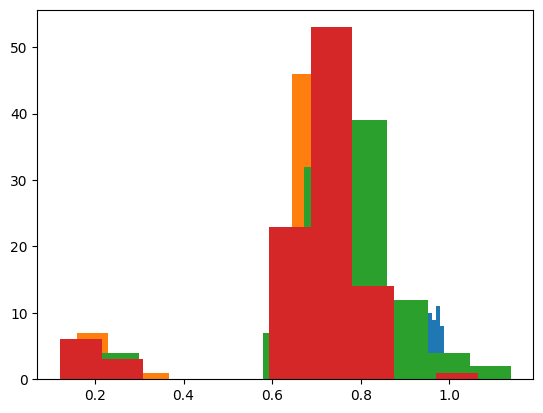

In [28]:

acc_oof = extract_acc(sim_out_oof)
acc_acdc = extract_acc(sim_out_acdc)
acc_winsim = extract_acc(sim_out_winsim)


plt.hist(empirical_accuracies['accuracy'])
plt.hist(acc_oof, label = 'Out-Of-Sample')
plt.hist(acc_acdc, label = 'ACDC')
plt.hist(acc_winsim, label = 'Winner Simulation')


# plt.hist(empirical_data['accuracies'])

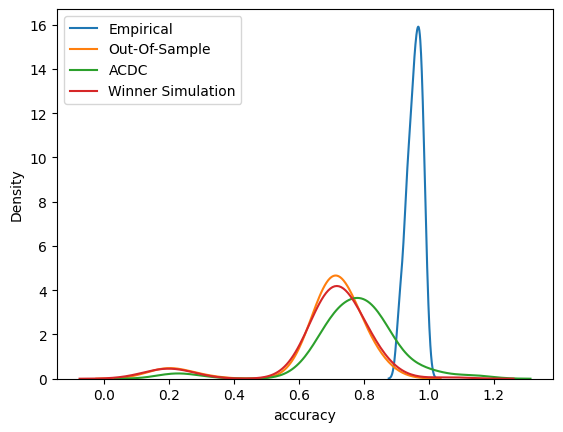

In [29]:
sns.kdeplot(empirical_accuracies['accuracy'], label = 'Empirical')
sns.kdeplot(acc_oof, label = 'Out-Of-Sample')
sns.kdeplot(acc_acdc, label = 'ACDC')
sns.kdeplot(acc_winsim, label = 'Winner Simulation')
plt.legend()

<Axes: ylabel='Density'>

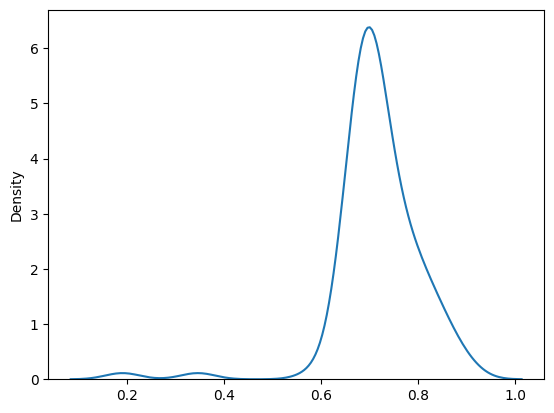

In [25]:
sns.kdeplot(acc_oof, label = 'Out-Of-Sample')